In [1]:
# Get files from google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Import necessary packages
import pickle
import os.path
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Function serves as work around for reading very large pickle files 
# when memory is limited
# Code taken from https://stackoverflow.com/questions/42653386/does-pickle-randomly-fail-with-oserror-on-large-files/42725930
def try_to_load_as_pickled_object_or_None(filepath):

    max_bytes = 2**31 - 1

    try:
        input_size = os.path.getsize(filepath)
        bytes_in = bytearray(0)
        with open(filepath, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        obj = pickle.loads(bytes_in)

    except:
        return None
    return obj

In [0]:
# Function to plot data after model is fit 
def plot_data(epoch_range, data1, data2, title, xlabel, ylabel, leg_loc="upper left"):

  # Create new figure and add necessary components
    plt.figure()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt1 = plt.plot(epoch_range, data1, label="Training")
    plt2 = plt.plot(epoch_range, data2, label="Validation")

    plt.legend(loc=leg_loc)
    plt.show()


In [0]:
# Read in training data
train_images = try_to_load_as_pickled_object_or_None('drive/My Drive/Colab Notebooks/train_max_x')
train_labels = pd.read_csv('drive/My Drive/Colab Notebooks/train_max_y.csv')
train_labels = train_labels.drop(columns='Id').to_numpy()            

In [0]:
# Read in testing data
test_images = pd.read_pickle('drive/My Drive/Colab Notebooks/test_max_x')

In [0]:
# [0:50000] included in case we want to limit number of data points
# Reshape data to fit into CNN
train_images = train_images[0:50000].reshape(50000, 128, 128, 1)
test_images = test_images[0:50000].reshape(10000, 128, 128, 1)

train_labels = keras.utils.to_categorical(train_labels)

In [0]:
# Function builds the CNN
def build_cnn(input_shape):

    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Conv2D(128, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(keras.layers.Conv2D(128, kernel_size=5, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Conv2D(256, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(keras.layers.Conv2D(256, kernel_size=3, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.Dropout(0.5))


    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(64, activation='relu'))  
    model.add(keras.layers.Dense(10, activation='softmax'))

    # Show a summary of model
    model.summary()

    return model

In [0]:
# Function compiles and fits a model using training data and parameters specified
def fit_cnn(train_images, train_labels, optimizer, opt_param, loss_function, metrics, epochs=15):
  
    if optimizer == 'nadam':
    opt = keras.optimizers.Nadam(schedule_decay=opt_param) # 0.004 (lr = 0.001)
    if optimizer == 'sgd':
    opt = keras.optimizers.SGD(lr=opt_param) # 0.00001
    if optimizer == 'adam':
    opt = keras.optimizers.adam() # default

    model.compile(optimizer=opt, loss=loss_function, metrics=metrics) #categorical_crossentropy, ["accuracy"]
    early_stopping = keras.callbacks.EarlyStopping(patience=3, verbose=2, mode='auto', min_delta=0.00005)

    model.fit(train_images, train_labels, validation_split=0.04, epochs=epochs, callbacks=[early_stopping], batch_size=32)

    return model

In [13]:
# Build Model
model = build_cnn((128,128,1))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 126, 126, 64)      640       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 124, 124, 64)      36928     
_________________________________________________________________
batch_normalization_4 (Batch (None, 124, 124, 64)      256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 58, 58, 128)       204928    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 54, 54, 128)      

In [14]:
# Fit model 
model = fit_cnn(train_images, train_labels, 'nadam', 0.004, 'categorical_crossentropy', ["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 48000 samples, validate on 2000 samples
Epoch 1/15
48000/48000 [==============================] - 123s 3ms/step - loss: 1.8813 - acc: 0.2760 - val_loss: 1.7800 - val_acc: 0.3370
Epoch 2/15
48000/48000 [==============================] - 102s 2ms/step - loss: 1.4682 - acc: 0.4279 - val_loss: 1.3531 - val_acc: 0.5215
Epoch 3/15
48000/48000 [==============================] - 102s 2ms/step - loss: 1.1484 - acc: 0.5981 - val_loss: 1.0687 - val_acc: 0.6415
Epoch 4/15
48000/48000 [==============================] - 102s 2ms/step - loss: 0.9401 - acc: 0.6732 - val_loss: 0.7668 - val_acc: 0.7125
Epoch 5/15
48000/48000 [==============================] - 102s 2ms/step - loss: 0.7006 - acc: 0.7765 - val_loss: 0.5051 - val_acc: 0.8420
Epoch 6/15
48000/48000 [==============================] - 102s 2ms/step - loss: 0.5591 - acc: 0.8241 - val_loss: 0.5097 - val_acc: 0.8320
Epoch 7/15
48000/48000 [===

In [20]:
# Get the history of the model
model_history = model.history.history
model_history

{'acc': [0.27595833333333336,
  0.42791666666666667,
  0.5980833333333333,
  0.6732083333333333,
  0.7764583333333334,
  0.8240833333333333,
  0.8486458333333333,
  0.8780833333333333,
  0.9019583333333333,
  0.9119375,
  0.9213958333333333,
  0.924625,
  0.9284166666666667,
  0.9310208333333333],
 'loss': [1.8812847968737285,
  1.468161240418752,
  1.1484387111266454,
  0.9401118058363597,
  0.7006354164381822,
  0.5591104730168979,
  0.4870756020496289,
  0.40782339134067297,
  0.3467479344823708,
  0.3103316341340542,
  0.2800966887585819,
  0.26873289889718094,
  0.25380660766859847,
  0.23827578979668518],
 'val_acc': [0.337,
  0.5215,
  0.6415,
  0.7125,
  0.842,
  0.832,
  0.8205,
  0.9225,
  0.943,
  0.9495,
  0.95,
  0.9485,
  0.9455,
  0.952],
 'val_loss': [1.7800255489349366,
  1.353081039428711,
  1.0686608543395997,
  0.7667552332878113,
  0.505105019569397,
  0.509687824845314,
  0.6844536342620849,
  0.2565367531478405,
  0.20140201371908187,
  0.19330831521749497,
  0.1

In [0]:
# Store history in variables
training_accuracies = model_history['acc']
training_losses = model_history['loss']
validation_accuracies = model_history['val_acc']
validation_losses = model_history['val_loss']

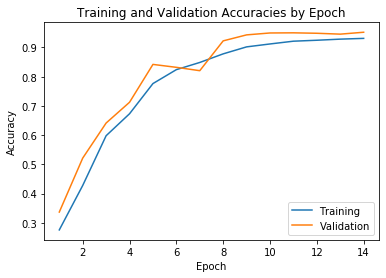

In [40]:
# Plot accuracy vs epoch
plot_data(np.arange(1,15), training_accuracies, validation_accuracies, "Training and Validation Accuracies by Epoch", "Epoch", "Accuracy", "lower right")

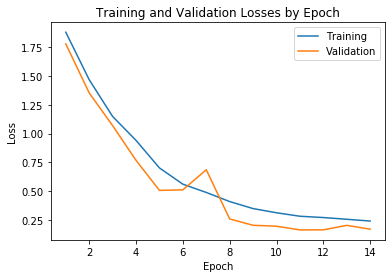

In [41]:
# Plot loss vs epoch
plot_data(np.arange(1,15), training_losses, validation_losses, "Training and Validation Losses by Epoch", "Epoch", "Loss", "upper right")